In [144]:
import pandas as pd
pd.set_option('display.max_rows', None)
from datetime import datetime as dt
import os
import re
import xlrd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight') # For plots
import numpy as np
from scipy import interpolate
import statsmodels
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import math
import calendar
import holidays
import tensorflow as tf
from fbprophet import Prophet
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as hac
import keras
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Forecasting time series with complex seasonal patterns
from tbats import TBATS, BATS

# Load mooving average methods
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
import pmdarima                            # for determining ARIMA orders

# Load specific clustering tools
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [3]:
path_git = 'https://raw.githubusercontent.com/danc248/data_science_lab_2021_final_project/main/pod_u1_u6_complete_time_series.csv'

In [4]:
file_csv1 = pd.read_csv(path_git,sep=';')
file_csv1['date']=pd.to_datetime(file_csv1['date'])
file_csv1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210432 entries, 0 to 210431
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   date                                  210432 non-null  datetime64[ns]
 1   POD                                   210432 non-null  object        
 2   FL_ORA_LEGALE                         207528 non-null  float64       
 3   CONSUMO_ATTIVA_PRELEVATA              207528 non-null  float64       
 4   CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA  207528 non-null  float64       
 5   POTENZA_MASSIMA                       169320 non-null  float64       
 6   TIPO_DATO                             207528 non-null  object        
 7   DATA                                  207528 non-null  float64       
 8   ORA                                   207528 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 14

In [5]:
file_csv1.head(2)

,date,POD,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,TIPO_DATO,DATA,ORA
0,2018-01-01 00:00:00,IT012E00491824,1.0,93.5,38.50,888.8,E,20180101.0,00:00:00
1,2018-01-01 00:15:00,IT012E00491824,1.0,91.3,35.75,888.8,E,20180101.0,00:15:00


In [6]:
pod_list = list(file_csv1['POD'].unique())
print(pod_list)
print('numero POD: ', len(pod_list))

['IT012E00491824', 'IT012E00491869']
numero POD:  2


In [7]:
pod1 = pod_list[0]
pod6 = pod_list[1]

In [8]:
pod_u1 = file_csv1[file_csv1['POD']==pod1]
pod_u6 = file_csv1[file_csv1['POD']==pod6]

pod_u1.set_index('date', inplace=True)
pod_u6.set_index('date', inplace=True)

print(pod_u1.shape)
print(pod_u6.shape)

(105216, 8)
(105216, 8)


In [9]:
pod_u1.head(2)

,POD,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,TIPO_DATO,DATA,ORA
date,,,,,,,,
2018-01-01 00:00:00,IT012E00491824,1.0,93.5,38.50,888.8,E,20180101.0,00:00:00
2018-01-01 00:15:00,IT012E00491824,1.0,91.3,35.75,888.8,E,20180101.0,00:15:00


In [10]:
pod_u6.head(2)

,POD,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,TIPO_DATO,DATA,ORA
date,,,,,,,,
2018-01-01 00:00:00,IT012E00491869,1.0,64.8,21.6,446.4,E,20180101.0,00:00:00
2018-01-01 00:15:00,IT012E00491869,1.0,66.0,25.2,446.4,E,20180101.0,00:15:00


In [11]:
pluto = pod_u1[pod_u1['CONSUMO_ATTIVA_PRELEVATA'].isna()]

list1 = list(pluto.index.date)
set(list1)

{datetime.date(2018, 3, 25),
 datetime.date(2019, 3, 31),
 datetime.date(2020, 3, 29),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 2),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 4),
 datetime.date(2020, 6, 5),
 datetime.date(2020, 6, 6),
 datetime.date(2020, 6, 7),
 datetime.date(2020, 6, 8),
 datetime.date(2020, 6, 9),
 datetime.date(2020, 6, 10),
 datetime.date(2020, 6, 11),
 datetime.date(2020, 6, 12),
 datetime.date(2020, 6, 13),
 datetime.date(2020, 6, 14),
 datetime.date(2020, 6, 15),
 datetime.date(2020, 6, 16),
 datetime.date(2020, 6, 17),
 datetime.date(2020, 6, 18),
 datetime.date(2020, 6, 19),
 datetime.date(2020, 6, 20),
 datetime.date(2020, 6, 21),
 datetime.date(2020, 6, 22),
 datetime.date(2020, 6, 23),
 datetime.date(2020, 6, 24),
 datetime.date(2020, 6, 25),
 datetime.date(2020, 6, 26),
 datetime.date(2020, 6, 27),
 datetime.date(2020, 6, 28),
 datetime.date(2020, 6, 29),
 datetime.date(2020, 6, 30)}

In [12]:
pluto = pod_u6[pod_u6['CONSUMO_ATTIVA_PRELEVATA'].isna()].iloc[:,8:11]
pluto

""
date
2018-03-25 02:00:00
2018-03-25 02:15:00
2018-03-25 02:30:00
2018-03-25 02:45:00
2019-03-31 02:00:00
2019-03-31 02:15:00
2019-03-31 02:30:00
2019-03-31 02:45:00
2020-03-29 02:00:00


In [13]:
pluto1 = pod_u1[(pod_u1['CONSUMO_ATTIVA_PRELEVATA'].isna()) & (pod_u1.index.month != 6)]
#pluto1 = pluto[pluto['month']!=6]

pluto6 = pod_u6[pod_u6['CONSUMO_ATTIVA_PRELEVATA'].isna()]
#pluto6 = pluto[pluto['month']!=6]

print(pluto1.shape)
print(pluto6.shape)

(12, 8)
(12, 8)


In [14]:
pluto1.index.equals(pluto6.index)

True

In [15]:
# let's erase the missing rows due to daylight savings time in march

daylight_savings = pod_u6[pod_u6['CONSUMO_ATTIVA_PRELEVATA'].isna()]
daylight_savings = list(daylight_savings.index)
pod_u1 = pod_u1.drop(daylight_savings)
pod_u6 = pod_u6.drop(daylight_savings)

print(len(pod_u1)==len(pod_u6))
print(pod_u6.shape)
print(pod_u6[pod_u6['CONSUMO_ATTIVA_PRELEVATA'].isna()])

True
(105204, 8)
Empty DataFrame
Columns: [POD, FL_ORA_LEGALE, CONSUMO_ATTIVA_PRELEVATA, CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA, POTENZA_MASSIMA, TIPO_DATO, DATA, ORA]
Index: []


In [16]:
pod_u1_hourly = pod_u1
pod_u6_hourly = pod_u6

pod_u1_hourly = pod_u1_hourly.resample('H').mean()
pod_u6_hourly = pod_u6_hourly.resample('H').mean()
print(pod_u1_hourly.shape)
print(pod_u6_hourly.shape)
print(len(pod_u1_hourly)==len(pod_u1_hourly))

(26304, 5)
(26304, 5)
True


In [17]:
pod_u6_hourly[pod_u6_hourly['CONSUMO_ATTIVA_PRELEVATA'].isna()]

,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,DATA
date,,,,,
2018-03-25 02:00:00,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:00:00,NaN,NaN,NaN,NaN,NaN
2020-03-29 02:00:00,NaN,NaN,NaN,NaN,NaN


In [18]:
daylight2 = pod_u6_hourly[pod_u6_hourly['CONSUMO_ATTIVA_PRELEVATA'].isna()]
daylight2 = list(daylight2.index)
daylight2

[Timestamp('2018-03-25 02:00:00'),
 Timestamp('2019-03-31 02:00:00'),
 Timestamp('2020-03-29 02:00:00')]

In [19]:
# use this cell if you want to keep every single hour (daylight savings time in march included)

list_starting_cols = ['FL_ORA_LEGALE',	'CONSUMO_ATTIVA_PRELEVATA',	'CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA',	'POTENZA_MASSIMA']	
list_df0 = [pod_u1_hourly, pod_u6_hourly]

for x in list_df0:
    for i in list_starting_cols:
        x[i].interpolate(method='linear', inplace=True)

pod_u1_hourly.loc['2020-06-01':'2020-06-30', 'CONSUMO_ATTIVA_PRELEVATA'] = np.nan

print('POD_U1 june-2020 data:')
print(pod_u1_hourly[pod_u1_hourly.index > '01-Jun-2020 00:00:00'][['CONSUMO_ATTIVA_PRELEVATA']].head(5))
print('')
print('POD_U1 march data:')
print(pod_u1_hourly.loc[daylight2, 'CONSUMO_ATTIVA_PRELEVATA'])
print('POD_U6 march data:')
print(pod_u6_hourly.loc[daylight2, 'CONSUMO_ATTIVA_PRELEVATA'])

POD_U1 june-2020 data:
                     CONSUMO_ATTIVA_PRELEVATA
date                                         
2020-06-01 01:00:00                       NaN
2020-06-01 02:00:00                       NaN
2020-06-01 03:00:00                       NaN
2020-06-01 04:00:00                       NaN
2020-06-01 05:00:00                       NaN

POD_U1 march data:
date
2018-03-25 02:00:00     81.2625
2019-03-31 02:00:00    107.5250
2020-03-29 02:00:00    106.7000
Name: CONSUMO_ATTIVA_PRELEVATA, dtype: float64
POD_U6 march data:
date
2018-03-25 02:00:00    72.675
2019-03-31 02:00:00    72.000
2020-03-29 02:00:00    79.050
Name: CONSUMO_ATTIVA_PRELEVATA, dtype: float64


In [20]:
# use this cell if you want to drop missing hours in march (daylight savings time)

#daylight2 = pod_u6_hourly[pod_u6_hourly['CONSUMO_ATTIVA_PRELEVATA'].isna()]
#daylight2 = list(daylight2.index)
#pod_u1_hourly = pod_u1_hourly.drop(daylight2)
#pod_u6_hourly = pod_u6_hourly.drop(daylight2)

#pod_u6_hourly[pod_u6_hourly['CONSUMO_ATTIVA_PRELEVATA'].isna()]

In [21]:
pod_list1 = [pod_u1_hourly, pod_u6_hourly]

pod_u1_hourly['POD'] = pod_list[0]  #?????????
pod_u6_hourly['POD'] = pod_list[1]

for i in pod_list1:
    i['year'] = i.index.year
    i['month'] = i.index.month
    i['day'] = i.index.day
    i['hour'] = i.index.hour
    i['day_of_week'] = i.index.day_name()
    i['day_of_week_number'] = i.index.dayofweek
    i['week_of_year'] = i.index.weekofyear
    i['day_of_year'] = i.index.dayofyear
    i.drop(columns=['DATA'], inplace=True)
    i['DATA'] = i.index.strftime("%Y-%m-%d")
    

pod_u1_hourly.tail(2)

,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,POD,year,month,day,hour,day_of_week,day_of_week_number,week_of_year,day_of_year,DATA
date,,,,,,,,,,,,,,
2020-12-31 22:00:00,1.0,133.5125,57.0625,444.4,IT012E00491824,2020,12,31,22,Thursday,3,53,366,2020-12-31
2020-12-31 23:00:00,1.0,133.3750,56.7875,444.4,IT012E00491824,2020,12,31,23,Thursday,3,53,366,2020-12-31


In [22]:
#pod_u6_hourly.head(2)
pod_u6_hourly[['CONSUMO_ATTIVA_PRELEVATA']].describe()

,CONSUMO_ATTIVA_PRELEVATA
count,26304.000000
mean,76.749324
std,18.107314
min,0.000000
25%,64.950000
50%,74.100000
75%,87.150000
max,150.150000


In [23]:
#missing data - POD_U1 time series
pod_u1_hourly[pod_u1_hourly['CONSUMO_ATTIVA_PRELEVATA'].isna()].DATA.unique()

array(['2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
       '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08',
       '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12',
       '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16',
       '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20',
       '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
       '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
       '2020-06-29', '2020-06-30'], dtype=object)

In [24]:
pod_u1_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2018-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   FL_ORA_LEGALE                         26304 non-null  float64
 1   CONSUMO_ATTIVA_PRELEVATA              25584 non-null  float64
 2   CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA  26304 non-null  float64
 3   POTENZA_MASSIMA                       26304 non-null  float64
 4   POD                                   26304 non-null  object 
 5   year                                  26304 non-null  int64  
 6   month                                 26304 non-null  int64  
 7   day                                   26304 non-null  int64  
 8   hour                                  26304 non-null  int64  
 9   day_of_week                           26304 non-null  object 
 10  day_of_week_number                    2

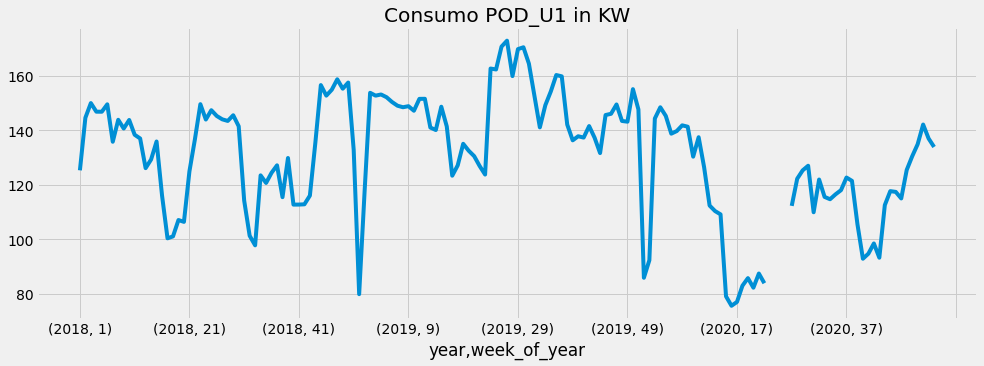

In [25]:
pod_u1_hourly.groupby(['year','week_of_year'])['CONSUMO_ATTIVA_PRELEVATA'].mean().plot(
                        style='-', 
                        figsize=(15,5), 
                        #color=color_pal[0], 
                        title='Consumo POD_U1 in KW')
plt.show()

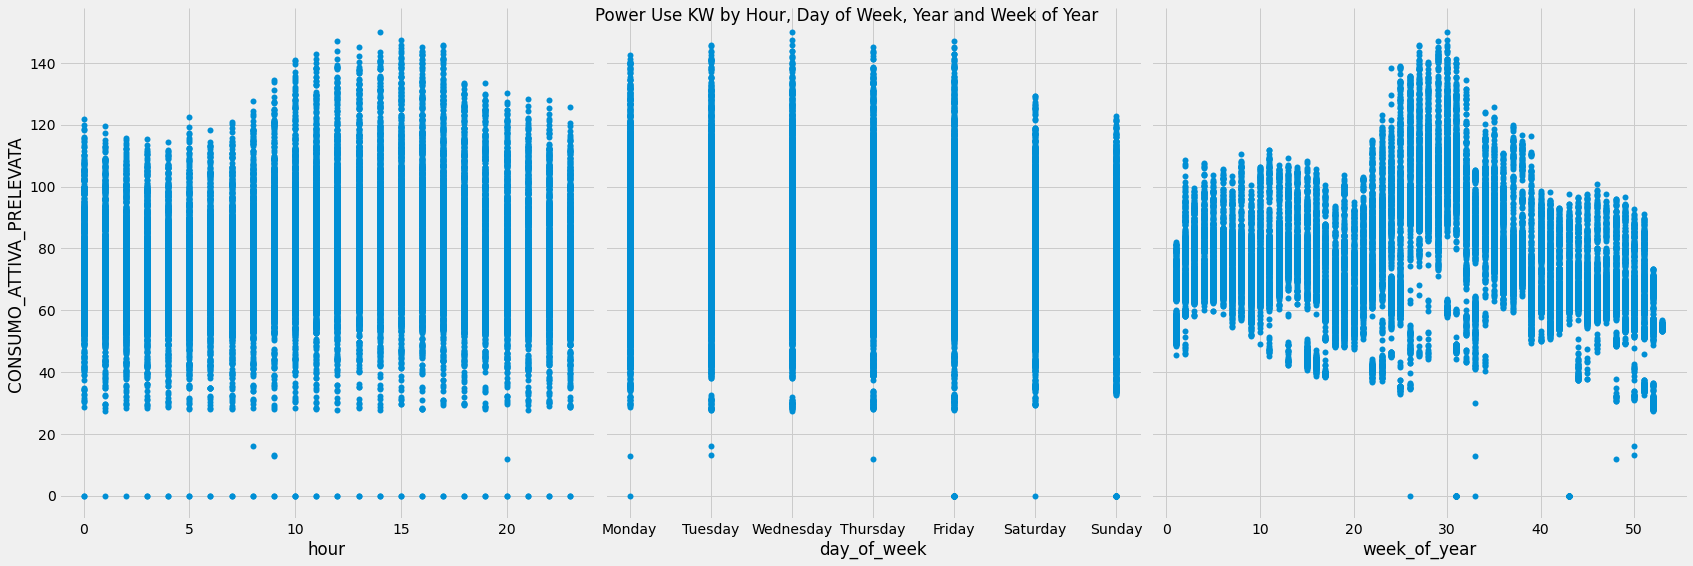

In [26]:
sns.pairplot(pod_u6_hourly,
             #hue='hour',
             x_vars=['hour','day_of_week',
                     'week_of_year'],
             y_vars='CONSUMO_ATTIVA_PRELEVATA',
             height=8, 
             #palette="husl",
             plot_kws={'alpha':1, 'linewidth':0}
            )
plt.suptitle('Power Use KW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [27]:
pod_test11 = pod_u1_hourly.copy()
pod_test66 = pod_u6_hourly.copy()

In [28]:
#pod_test11.groupby(['year'])['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U1')

In [29]:
#pod_test66.groupby(['year'])['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U1')

<AxesSubplot:title={'center':'Consumo POD_U6 in KW'}, xlabel='month,day'>

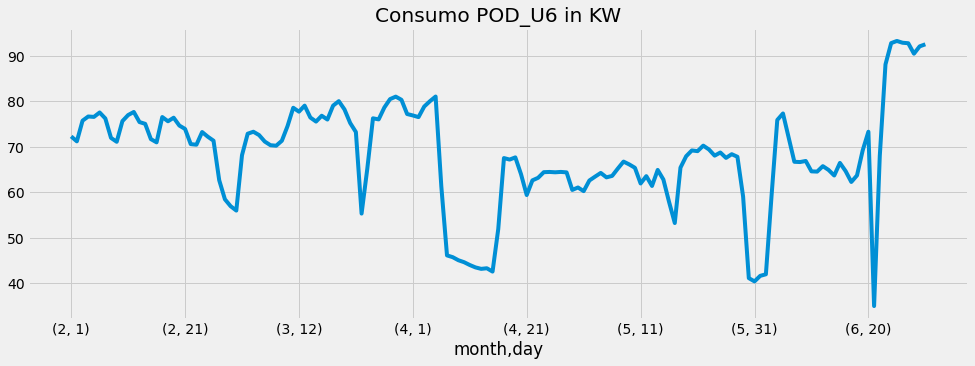

In [30]:
pod999 = pod_u6_hourly.copy()
pod999 = pod999[pod999.index >'01-Feb-2020']
pod999 = pod999[pod999.index <'01-Jul-2020']

pod999.groupby(['month','day'])['CONSUMO_ATTIVA_PRELEVATA'].mean().plot(
                        style='-', 
                        figsize=(15,5), 
                        #color=color_pal[0], 
                        title='Consumo POD_U6 in KW')

<AxesSubplot:title={'center':'POD_U1'}, xlabel='year,month'>

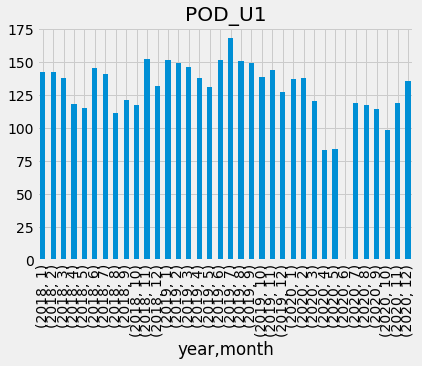

In [31]:
pod_test11.groupby(['year','month'])['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U1')

In [32]:
#pod_test11.groupby('month')['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U1')

In [33]:
#pod_test66.groupby('month')['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U6')

In [34]:
#pod_test11.groupby('day_of_week_number')['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U1')

In [35]:
#pod_test66.groupby('day_of_week_number')['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U6')

In [36]:
#pod_test11.groupby('hour')['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U6')

In [37]:
#pod_test66.groupby('hour')['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U6')

col_list = ['CONSUMO_ATTIVA_PRELEVATA','year', 'month', 'day', 'hour', 'day_of_week',
                      'day_of_week_number']

pod_u1_inter = pod_u1_hourly[col_list]

list_linear =[]
for i in range(24):
    pod_u1_inter1 = pod_u1_inter[pod_u1_inter['hour']==i]
    pod_u1_linear = pod_u1_inter1.interpolate(method='linear')
    list_linear.append(pod_u1_linear)

#pod_u1_spline = pod_u1_inter.interpolate(method='spline', order=2)
#pod_u1_poly = pod_u1_inter.interpolate(method='polynomial',order=2)
#pod_u6_linear = pod_u6_inter.interpolate(method='linear')
#pod_u6_spline = pod_u6_inter.interpolate(method='spline', order=2)
#pod_u6_poly = pod_u6_inter.interpolate(method='polynomial',order=2)
    

#pod_u1_linear.groupby(['year','month'])['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U1')
#pod_u1_linear[(pod_u1_inter['year']==2020)&(pod_u1_inter['month']==6)]



full_df1 = pd.concat(list_linear,ignore_index=False)
full_df1 = full_df1[(full_df1['year']==2020) & (full_df1['month']>=5) & (full_df1['month']<8)]
full_df1 = full_df1.sort_index()
full_df1.groupby(['month','day'])['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U1')

In [38]:
#test_monthly_data = pod_u1_hourly.resample('M').mean()
#test_monthly_data.shape

In [39]:
#test_monthly_data = test_monthly_data.interpolate(method='linear')
#print('linear interpolation of June 2020')
#print(test_monthly_data[(test_monthly_data['year']==2020) & (test_monthly_data['month']==6)].iloc[:,1])
#print('')
#print('let us see if we still have missing data:')
#print(test_monthly_data[test_monthly_data['CONSUMO_ATTIVA_PRELEVATA'].isna()])
#test_monthly_data.groupby(['year','month'])['CONSUMO_ATTIVA_PRELEVATA'].mean().plot.bar(title='POD_U1')

In [40]:
#we have eliminated some rows in march --> daylight savings time

In [41]:
#prova ad usare prophet

In [42]:
#esempio di forecasting con prophet

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet 

In [43]:
# dovrai stimare il valore medio di giugno 2020 del primo POD
#però fai attenzione alla distribuzione di giorni feriali/festivi di giugno 2020 perchè è diversa
#dalla distribuzione dei mesi precedenti

In [44]:
start_year = pod_u6_hourly.year.min()
final_year = pod_u6_hourly.year.max()

#print(start_year)
year_list = list(np.arange(start_year, final_year+1))
year_list

[2018, 2019, 2020]

In [45]:
holiday_date = []
holiday_name = []
  
# Print all the holidays in UnitedKingdom in year 2018
for ptr in holidays.IT(years = year_list, prov='MI').items():
    holiday_date.append(ptr[0])
    holiday_name.append(ptr[1])
    print(ptr)

(datetime.date(2018, 1, 1), 'Capodanno')
(datetime.date(2018, 1, 6), 'Epifania del Signore')
(datetime.date(2018, 4, 1), 'Pasqua di Resurrezione')
(datetime.date(2018, 4, 2), "Lunedì dell'Angelo")
(datetime.date(2018, 4, 25), 'Festa della Liberazione')
(datetime.date(2018, 5, 1), 'Festa dei Lavoratori')
(datetime.date(2018, 6, 2), 'Festa della Repubblica')
(datetime.date(2018, 8, 15), 'Assunzione della Vergine')
(datetime.date(2018, 11, 1), 'Tutti i Santi')
(datetime.date(2018, 12, 8), 'Immacolata Concezione')
(datetime.date(2018, 12, 25), 'Natale')
(datetime.date(2018, 12, 26), 'Santo Stefano')
(datetime.date(2018, 12, 7), "Sant'Ambrogio")
(datetime.date(2019, 1, 1), 'Capodanno')
(datetime.date(2019, 1, 6), 'Epifania del Signore')
(datetime.date(2019, 4, 21), 'Pasqua di Resurrezione')
(datetime.date(2019, 4, 22), "Lunedì dell'Angelo")
(datetime.date(2019, 4, 25), 'Festa della Liberazione')
(datetime.date(2019, 5, 1), 'Festa dei Lavoratori')
(datetime.date(2019, 6, 2), 'Festa della Rep

In [46]:
type(holiday_date[0])

datetime.date

In [47]:
d = {'date': holiday_date, 'holiday_name': holiday_name}
holiday_df = pd.DataFrame(d)
holiday_df['date'] = holiday_df['date'].apply(pd.to_datetime)
#holiday_df['year'] = holiday_df['date'].dt.year
#holiday_df['month'] = holiday_df['date'].dt.month
#holiday_df['day'] = holiday_df['date'].dt.day
#holiday_df['hour'] = holiday_df['date'].dt.hour
holiday_df = holiday_df.set_index('date')
holiday_df = holiday_df.sort_index()
holiday_df['DATA'] = holiday_df.index.strftime("%Y-%m-%d")
#holiday_df = holiday_df.asfreq('H', method='ffill')
holiday_df.head()

,holiday_name,DATA
date,,
2018-01-01,Capodanno,2018-01-01
2018-01-06,Epifania del Signore,2018-01-06
2018-04-01,Pasqua di Resurrezione,2018-04-01
2018-04-02,Lunedì dell'Angelo,2018-04-02
2018-04-25,Festa della Liberazione,2018-04-25


In [48]:
holiday_date1 = list(holiday_df['DATA'])

def feste_calendario(x):
    if x in holiday_date1:
        w = 1
    else:
        w = 0
    return w

In [49]:
pod_list1 = [pod_u1_hourly, pod_u6_hourly]

pod_list10 = []

#for i in pod_list1:
    #i.drop(columns=['DATA'], inplace=True)
    #i['DATA'] = i.index.strftime("%Y%m%d")
    #i['holiday_binary'] = i['DATA'].apply(feste_calendario)
    #i.drop(columns=['DATA'], inplace=True)
    #i.head(2)
    
for i in pod_list1:
    i['holiday_binary'] = i['DATA'].apply(feste_calendario)
    i = i.reset_index()
    w = pd.merge(i, holiday_df, how='left', on='DATA')
    w = w.set_index('date')
    pod_list10.append(w)

    
pod_u1_new = pod_list10[0]
pod_u6_new = pod_list10[1]

In [50]:
pod_u6_new.head(2)

,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,POD,year,month,day,hour,day_of_week,day_of_week_number,week_of_year,day_of_year,DATA,holiday_binary,holiday_name
date,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1.0,64.50,22.95,446.4,IT012E00491869,2018,1,1,0,Monday,0,1,1,2018-01-01,1,Capodanno
2018-01-01 01:00:00,1.0,64.35,23.25,446.4,IT012E00491869,2018,1,1,1,Monday,0,1,1,2018-01-01,1,Capodanno


In [51]:
holiday_df0 = pod_u1_new[['holiday_name']].copy()
holiday_df0 = holiday_df0[holiday_df0['holiday_name'] \
                    .isna()==False] \
                    .reset_index() \
                    .rename(columns={'date':'ds', 'holiday_name':'holiday'})
holiday_df0['ds'] = pd.to_datetime(holiday_df0['ds'])
holiday_df0.head()

,ds,holiday
0,2018-01-01 00:00:00,Capodanno
1,2018-01-01 01:00:00,Capodanno
2,2018-01-01 02:00:00,Capodanno
3,2018-01-01 03:00:00,Capodanno
4,2018-01-01 04:00:00,Capodanno


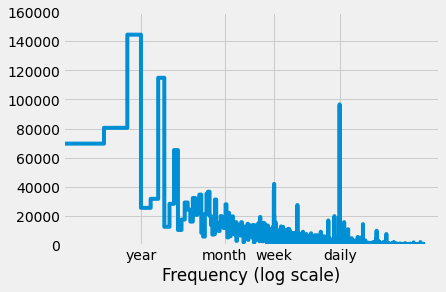

In [52]:
#fourier - frequency

df1 = pod_u6_new.copy()
fft = tf.signal.rfft(df1['CONSUMO_ATTIVA_PRELEVATA'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['CONSUMO_ATTIVA_PRELEVATA'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 160000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12, 52 ,365.2524], labels=['year', 'month', 'week', 'daily'])
_ = plt.xlabel('Frequency (log scale)')

In [656]:
#esempio di forecasting con prophet

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet 

In [56]:
split_date = '01-Jul-2020'
split_date1 = '01-Jun-2020'
df22 = pod_u1_new.copy()
#pjme_train = pjme.loc[pjme.index <= split_date].copy()
#pjme_test = pjme.loc[pjme.index > split_date].copy()

df22 = df22.drop(df22[(df22.year == 2020) & (df22.month == 6)].index)
df22 = df22[['CONSUMO_ATTIVA_PRELEVATA']]

df22 = df22.reset_index()
df22 = df22.rename(columns={'date':'ds','CONSUMO_ATTIVA_PRELEVATA':'y'})

#df22.head(2)

model = Prophet()
model.fit(df22)


df33 = pod_u1_new.copy()
df33 = df33[(df33.index >= split_date1) & (df33.index < split_date)]
df33 = df33[['CONSUMO_ATTIVA_PRELEVATA']]
df33 = df33.reset_index()
df33 = df33.rename(columns={'date':'ds','CONSUMO_ATTIVA_PRELEVATA':'y'})
df33 = df33[['ds']]
#df33.tail()

pjme_test_fcst = model.predict(df33)
#pjme_test_fcst.head()


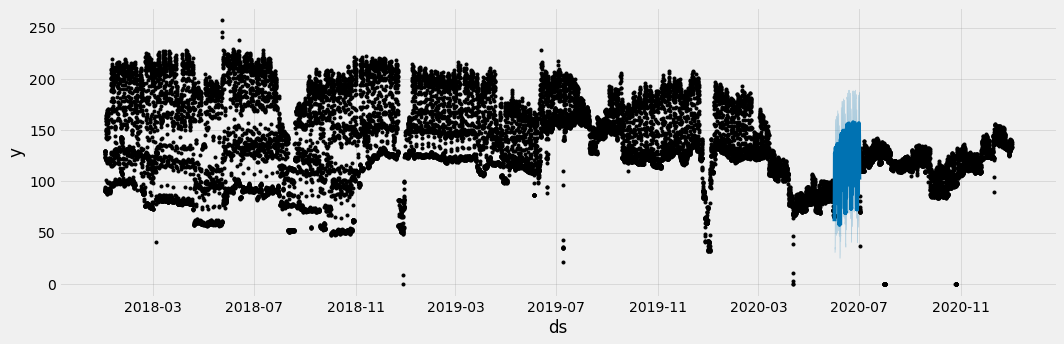

In [57]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

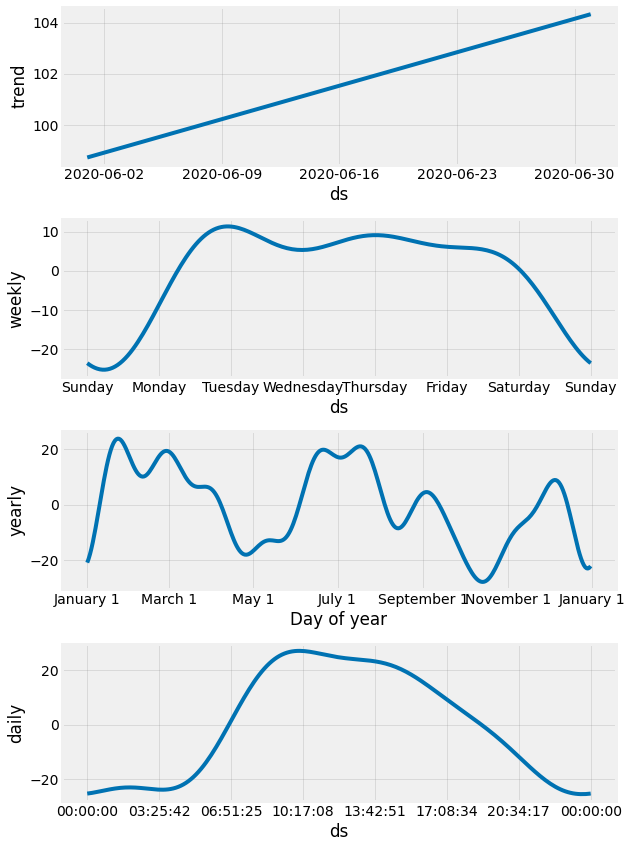

In [58]:
fig = model.plot_components(pjme_test_fcst)

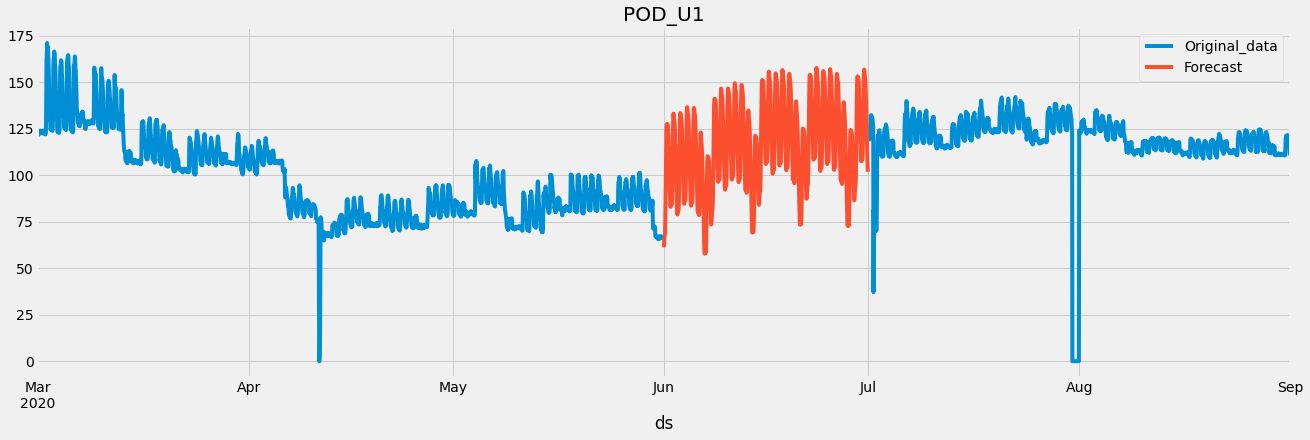

In [59]:
df44 = pjme_test_fcst[['ds','yhat']]

df44 = df44.rename(columns={'yhat':'y'})

#df555 = pd.concat([df22, df44])
#df555 = df555.set_index('ds')
#df555[(df555.index >= '01-May-2020') & (df555.index < '01-Aug-2020')].plot(figsize=(15,5))
#plt.ylim(0, 160)
#plt.show()

df_lp = df22.copy()
df_lp1 = df44.copy()

df_lp = df_lp.set_index('ds')
df_lp1 = df_lp1.set_index('ds')

df_lp = df_lp.rename(columns={'y': 'Original_data'})
df_lp1 = df_lp1.rename(columns={'y': 'Forecast'})



df_lp[(df_lp.index >= '01-Mar-2020') & (df_lp.index <= '01-Sep-2020')] \
            .join(df_lp1, how='outer') \
            .plot(figsize=(20,6), title='POD_U1', style='-')
plt.show()

In [131]:
#let's run prophet model with holidays (02-Jun-2020)

split_date = '01-Jul-2020'
split_date1 = '01-Jun-2020'
df22 = pod_u1_new.copy()
#pjme_train = pjme.loc[pjme.index <= split_date].copy()
#pjme_test = pjme.loc[pjme.index > split_date].copy()

df22 = df22.drop(df22[(df22.year == 2020) & (df22.month == 6)].index)
df22 = df22[['CONSUMO_ATTIVA_PRELEVATA']]

df22 = df22.reset_index()
df22 = df22.rename(columns={'date':'ds','CONSUMO_ATTIVA_PRELEVATA':'y'})

#df22.head(2)

model = Prophet(holidays=holiday_df0, )
model.fit(df22)


df33 = pod_u1_new.copy()
df33 = df33[(df33.index >= split_date1) & (df33.index < split_date)]
df33 = df33[['CONSUMO_ATTIVA_PRELEVATA']]
df33 = df33.reset_index()
df33 = df33.rename(columns={'date':'ds','CONSUMO_ATTIVA_PRELEVATA':'y'})
df33 = df33[['ds']]
#df33.tail()

pjme_test_fcst_hol = model.predict(df33)
#pjme_test_fcst.head()



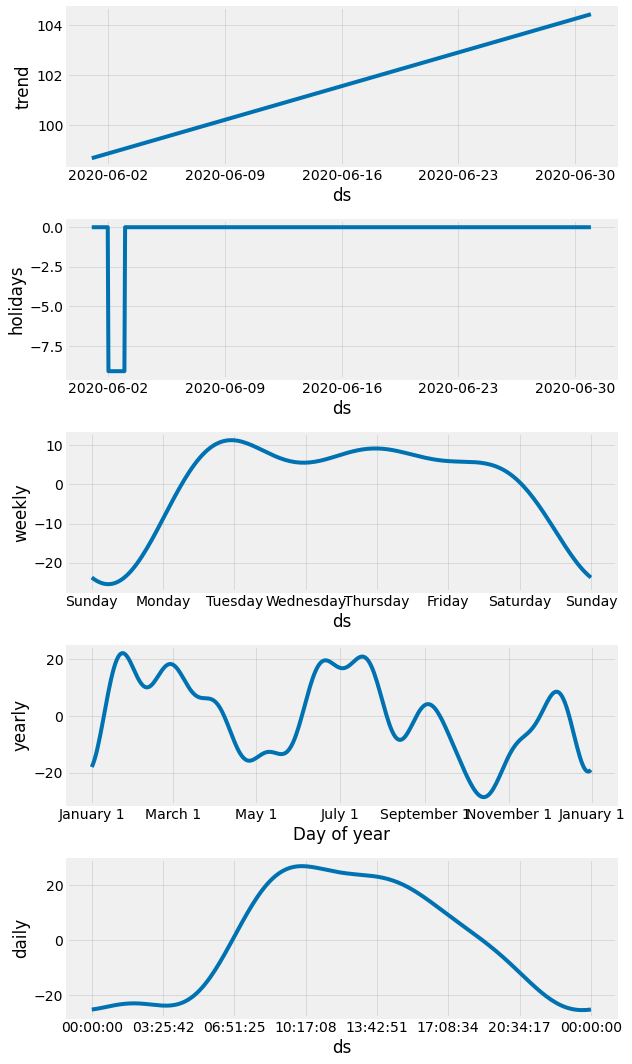

In [132]:
fig = model.plot_components(pjme_test_fcst_hol)

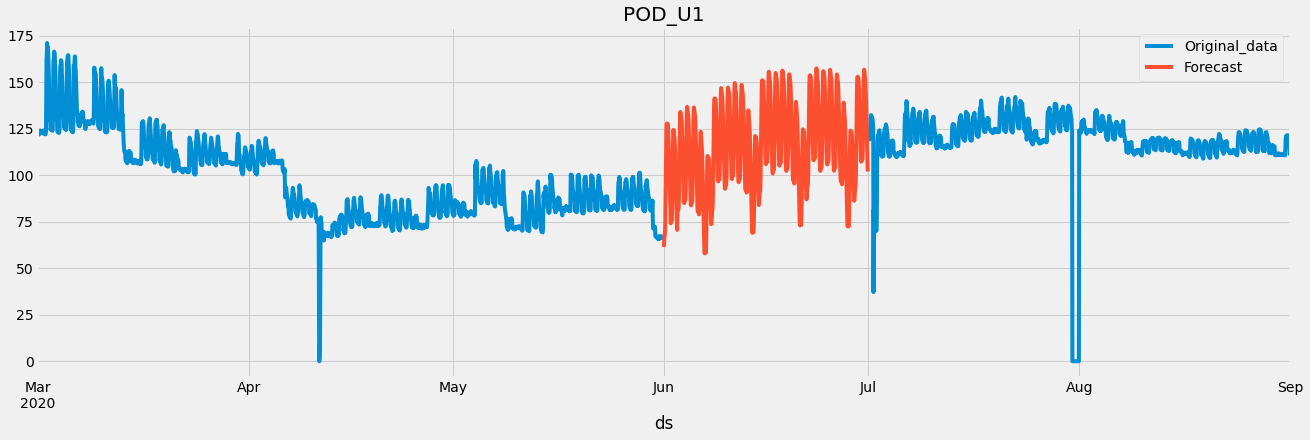

In [133]:
df44_hol = pjme_test_fcst_hol[['ds','yhat']]

df44_hol = df44_hol.rename(columns={'yhat':'y'})

#df555_hol = pd.concat([df22, df44_hol])
#df555_hol = df555_hol.set_index('ds')
#df555_hol[(df555_hol.index >= '01-May-2020') & (df555.index < '01-Aug-2020')].plot(figsize=(15,5))
#plt.ylim(0, 160)
#plt.show()

df_lp = df22.copy()
df_lp1_hol = df44_hol.copy()

df_lp = df_lp.set_index('ds')
df_lp1_hol = df_lp1_hol.set_index('ds')

df_lp = df_lp.rename(columns={'y': 'Original_data'})
df_lp1_hol = df_lp1_hol.rename(columns={'y': 'Forecast'})



df_lp[(df_lp.index >= '01-Mar-2020') & (df_lp.index <= '01-Sep-2020')] \
            .join(df_lp1_hol, how='outer') \
            .plot(figsize=(20,6), title='POD_U1', style='-')
plt.show()

In [63]:
df_lp1[df_lp1.index == '02-Jun-2020'].mean()  #forecast by prophet

Forecast    82.981166
dtype: float64

In [64]:
df_lp1_hol[df_lp1_hol.index == '02-Jun-2020'].mean()  #forecast by prophet with holidays (02-Jun-2020)

Forecast    74.160846
dtype: float64

In [65]:
#complete time series - POD U1

In [66]:
df555_hol = pd.concat([df22, df44_hol])
#df555_hol = df555_hol.set_index('ds').sort_index()
df555_hol['ds'] = pd.to_datetime(df555_hol['ds'])

df555_hol = df555_hol.rename(columns={'ds':'date'}) \
                .set_index('date') \
                .sort_index()



In [67]:
new_data = df555_hol.copy()

new_data.head()

,y
date,
2018-01-01 00:00:00,91.7125
2018-01-01 01:00:00,91.1625
2018-01-01 02:00:00,90.7500
2018-01-01 03:00:00,93.5000
2018-01-01 04:00:00,123.6125


In [68]:
new_data_pod_u1 = pd.concat([pod_u1_new, new_data], axis=1)
new_data_pod_u1[new_data_pod_u1.DATA == '2020-06-01'].head()

,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,POD,year,month,day,hour,day_of_week,day_of_week_number,week_of_year,day_of_year,DATA,holiday_binary,holiday_name,y
date,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,2.0,NaN,23.414667,444.4,IT012E00491824,2020,6,1,0,Monday,0,23,153,2020-06-01,0,NaN,61.420220
2020-06-01 01:00:00,2.0,NaN,23.454334,444.4,IT012E00491824,2020,6,1,1,Monday,0,23,153,2020-06-01,0,NaN,64.375436
2020-06-01 02:00:00,2.0,NaN,23.494001,444.4,IT012E00491824,2020,6,1,2,Monday,0,23,153,2020-06-01,0,NaN,66.726692
2020-06-01 03:00:00,2.0,NaN,23.533669,444.4,IT012E00491824,2020,6,1,3,Monday,0,23,153,2020-06-01,0,NaN,67.672386
2020-06-01 04:00:00,2.0,NaN,23.573336,444.4,IT012E00491824,2020,6,1,4,Monday,0,23,153,2020-06-01,0,NaN,69.178859


In [69]:
new_data_pod_u1['check'] = new_data_pod_u1['y'] - new_data_pod_u1['CONSUMO_ATTIVA_PRELEVATA']
print(list(new_data_pod_u1.check.unique()))  #valori della colonna "Check"

[0.0, nan]


In [70]:
reference_col_list = list(pod_u6_new.columns)

In [71]:
reference_col_list1 = reference_col_list
reference_col_list1[1] = 'y'
reference_col_list1

['FL_ORA_LEGALE',
 'y',
 'CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA',
 'POTENZA_MASSIMA',
 'POD',
 'year',
 'month',
 'day',
 'hour',
 'day_of_week',
 'day_of_week_number',
 'week_of_year',
 'day_of_year',
 'DATA',
 'holiday_binary',
 'holiday_name']

In [72]:
u1_pod = new_data_pod_u1.copy()
u1_pod = u1_pod[reference_col_list1]
u1_pod = u1_pod.rename(columns={'y':'CONSUMO_ATTIVA_PRELEVATA'})

u1_pod.head(2)

,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,POD,year,month,day,hour,day_of_week,day_of_week_number,week_of_year,day_of_year,DATA,holiday_binary,holiday_name
date,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1.0,91.7125,36.4375,888.8,IT012E00491824,2018,1,1,0,Monday,0,1,1,2018-01-01,1,Capodanno
2018-01-01 01:00:00,1.0,91.1625,36.5750,888.8,IT012E00491824,2018,1,1,1,Monday,0,1,1,2018-01-01,1,Capodanno


In [73]:
u1_pod[u1_pod.CONSUMO_ATTIVA_PRELEVATA.isna()==True]

,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,POD,year,month,day,hour,day_of_week,day_of_week_number,week_of_year,day_of_year,DATA,holiday_binary,holiday_name
date,,,,,,,,,,,,,,,,


In [74]:
u6_pod = pod_u6_new.copy()

In [75]:
len(u1_pod) == len(u6_pod)

True

In [76]:
u1_pod.shape == u6_pod.shape

True

In [77]:
print('i due dataframe finali sono: ')
print('')
print('u1_pod')
print('u6_pod')

i due dataframe finali sono: 

u1_pod
u6_pod


In [78]:
#let's run prophet model with holidays (02-Jun-2020) - excluding 2018 data from the training set

split_date = '01-Jul-2020'
split_date1 = '01-Jun-2020'
df22_2019 = pod_u1_new[pod_u1_new.index >= '01-Jan-2019'].copy()   #!!!!!
#pjme_train = pjme.loc[pjme.index <= split_date].copy()
#pjme_test = pjme.loc[pjme.index > split_date].copy()

df22_2019 = df22_2019.drop(df22_2019[(df22_2019.year == 2020) & (df22_2019.month == 6)].index)
df22_2019 = df22_2019[['CONSUMO_ATTIVA_PRELEVATA']]

df22_2019 = df22_2019.reset_index()
df22_2019 = df22_2019.rename(columns={'date':'ds','CONSUMO_ATTIVA_PRELEVATA':'y'})

#df22.head(2)

model = Prophet(holidays=holiday_df0)
model.fit(df22_2019)


df33 = pod_u1_new.copy()
df33 = df33[(df33.index >= split_date1) & (df33.index < split_date)]
df33 = df33[['CONSUMO_ATTIVA_PRELEVATA']]
df33 = df33.reset_index()
df33 = df33.rename(columns={'date':'ds','CONSUMO_ATTIVA_PRELEVATA':'y'})
df33 = df33[['ds']]
#df33.tail()

pjme_test_fcst_hol_2019 = model.predict(df33)
#pjme_test_fcst.head()



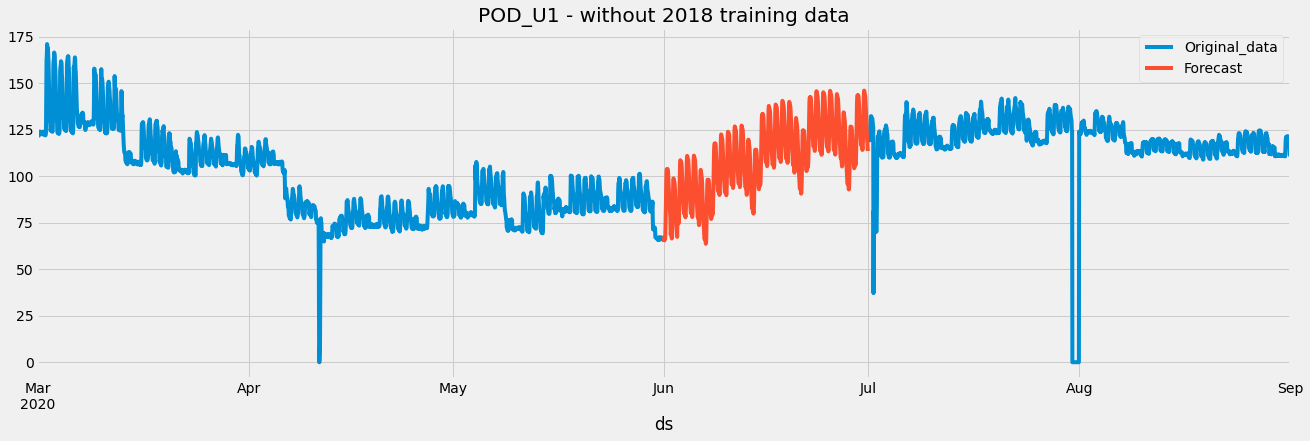

In [79]:
df44_hol_2019 = pjme_test_fcst_hol_2019[['ds','yhat']]

df44_hol_2019 = df44_hol_2019.rename(columns={'yhat':'y'})

#df555_hol = pd.concat([df22, df44_hol])
#df555_hol = df555_hol.set_index('ds')
#df555_hol[(df555_hol.index >= '01-May-2020') & (df555.index < '01-Aug-2020')].plot(figsize=(15,5))
#plt.ylim(0, 160)
#plt.show()

df_lp_2019 = df22_2019.copy()
df_lp1_hol_2019 = df44_hol_2019.copy()

df_lp_2019 = df_lp_2019.set_index('ds')
df_lp1_hol_2019 = df_lp1_hol_2019.set_index('ds')

df_lp_2019 = df_lp_2019.rename(columns={'y': 'Original_data'})
df_lp1_hol_2019 = df_lp1_hol_2019.rename(columns={'y': 'Forecast'})



df_lp_2019[(df_lp_2019.index >= '01-Mar-2020') & (df_lp_2019.index <= '01-Sep-2020')] \
            .join(df_lp1_hol_2019, how='outer') \
            .plot(figsize=(20,6), title='POD_U1 - without 2018 training data', style='-')
plt.show()

In [80]:
u1_pod.groupby(['year','month'])['CONSUMO_ATTIVA_PRELEVATA'].std()

year  month
2018  1        40.256784
      2        44.347505
      3        52.669557
      4        53.980576
      5        56.741077
      6        50.818025
      7        48.300881
      8        37.915193
      9        51.924147
      10       58.736690
      11       36.703531
      12       47.617351
2019  1        29.295887
      2        30.504636
      3        31.051008
      4        29.860838
      5        22.807602
      6        29.852859
      7        22.298879
      8        11.543225
      9        20.847223
      10       25.071915
      11       26.818429
      12       40.976503
2020  1        31.825520
      2        20.073466
      3        15.791257
      4        14.687660
      5         8.925692
      6        24.015338
      7        24.171067
      8         5.624818
      9        13.518243
      10       21.160927
      11        8.891463
      12        8.146563
Name: CONSUMO_ATTIVA_PRELEVATA, dtype: float64

In [81]:
pod_u1_hourly.groupby(['year'])['CONSUMO_ATTIVA_PRELEVATA'].std()

year
2018    50.626304
2019    29.481694
2020    25.358399
Name: CONSUMO_ATTIVA_PRELEVATA, dtype: float64

In [82]:
u1_pod['dummy_covid'] = np.where(u1_pod.index >= '08-Mar-2020', 1, 0)
u6_pod['dummy_covid'] = np.where(u6_pod.index >= '08-Mar-2020', 1, 0)

u6_pod[u6_pod.index >= '08-Mar-2020'].head(2)

,FL_ORA_LEGALE,CONSUMO_ATTIVA_PRELEVATA,CONSUMO_REATTIVA_INDUTTIVA_PRELEVATA,POTENZA_MASSIMA,POD,year,month,day,hour,day_of_week,day_of_week_number,week_of_year,day_of_year,DATA,holiday_binary,holiday_name,dummy_covid
date,,,,,,,,,,,,,,,,,
2020-03-08 00:00:00,1.0,70.05,34.2,372.0,IT012E00491869,2020,3,8,0,Sunday,6,10,68,2020-03-08,0,NaN,1
2020-03-08 01:00:00,1.0,66.45,31.8,372.0,IT012E00491869,2020,3,8,1,Sunday,6,10,68,2020-03-08,0,NaN,1


## Clustering

In [143]:
spiderman = u6_pod['CONSUMO_ATTIVA_PRELEVATA'].copy()

mySeries = []
#name_mySeries = []
hour_range = range(24)

for i in hour_range:
    df0 = spiderman[spiderman.index.hour == i]
    mySeries.append(df0)
    #name_mySeries.append(i)
    
mySeries[0].head()

date
2018-01-01    64.50
2018-01-02    63.90
2018-01-03    79.05
2018-01-04    75.00
2018-01-05    78.75
Name: CONSUMO_ATTIVA_PRELEVATA, dtype: float64

In [85]:
for i in hour_range:
    print(mySeries[i].shape)

(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)
(1096,)


In [86]:
len(mySeries[0])

1096

# Hierarchical Clustering

In [103]:
def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
            plt.show()

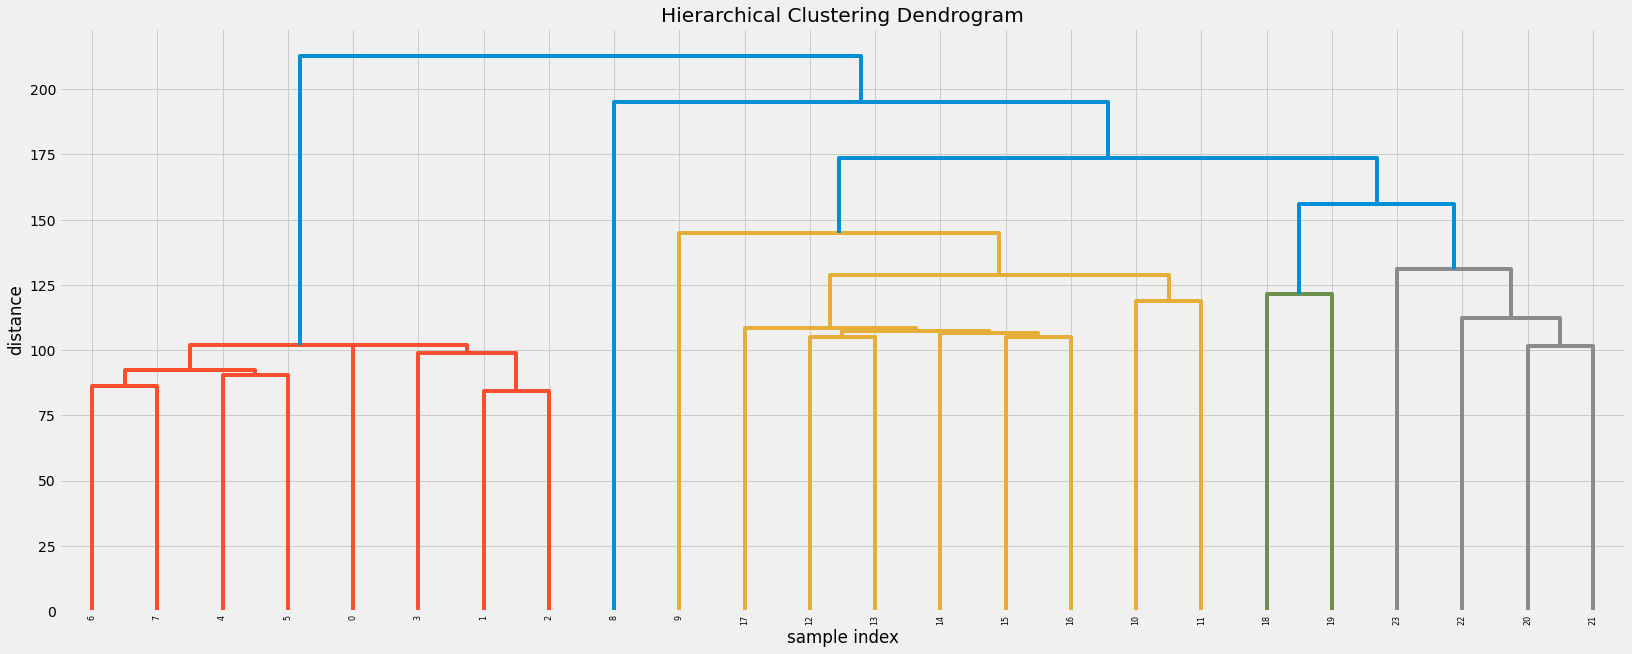

In [111]:
# Do the clustering
Z = hac.linkage(mySeries, method='single', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [112]:
print_clusters(mySeries, Z, 3, plot=False)

Cluster 1 number of entries 8
Cluster 3 number of entries 1
Cluster 2 number of entries 15


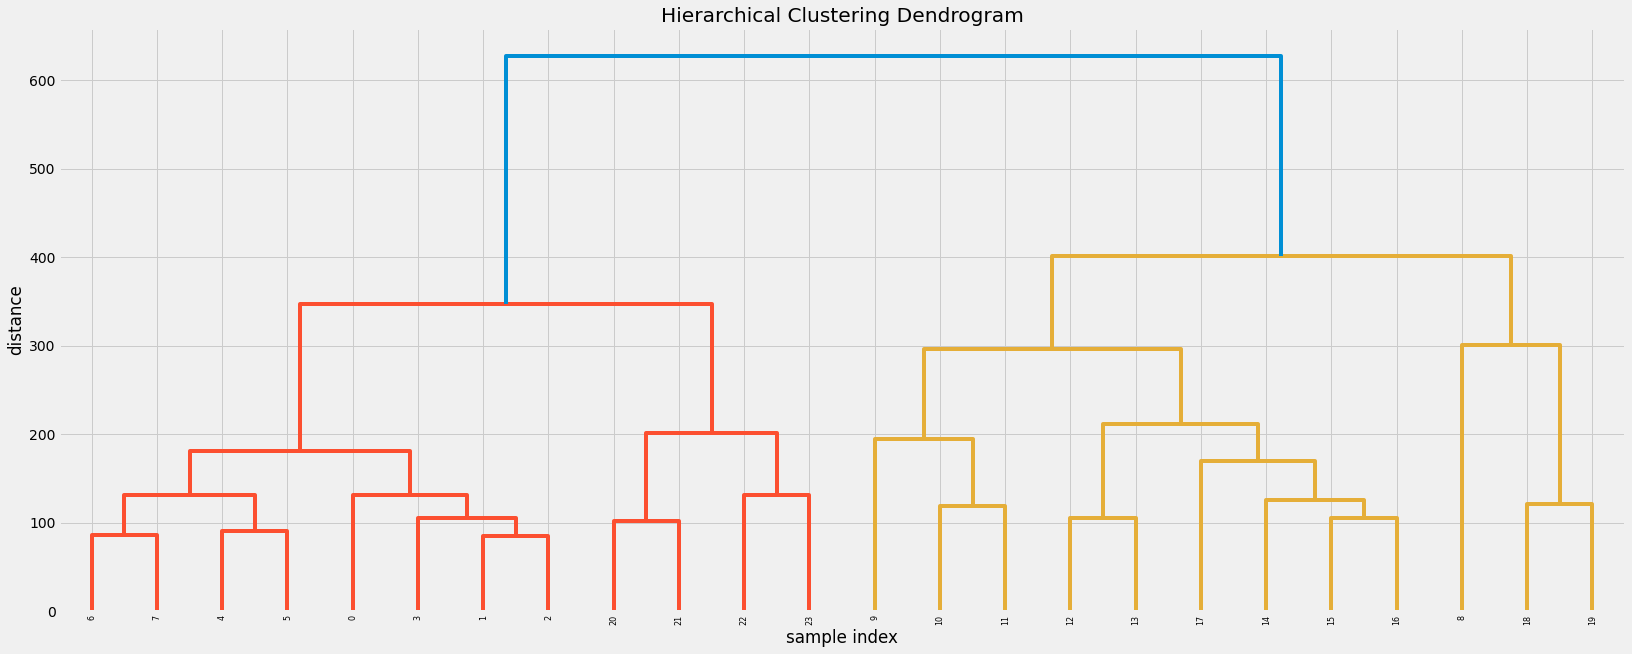

In [113]:
# Do the clustering
Z = hac.linkage(mySeries, method='complete', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [114]:
print_clusters(mySeries, Z, 3, plot=False)

Cluster 1 number of entries 12
Cluster 3 number of entries 3
Cluster 2 number of entries 9


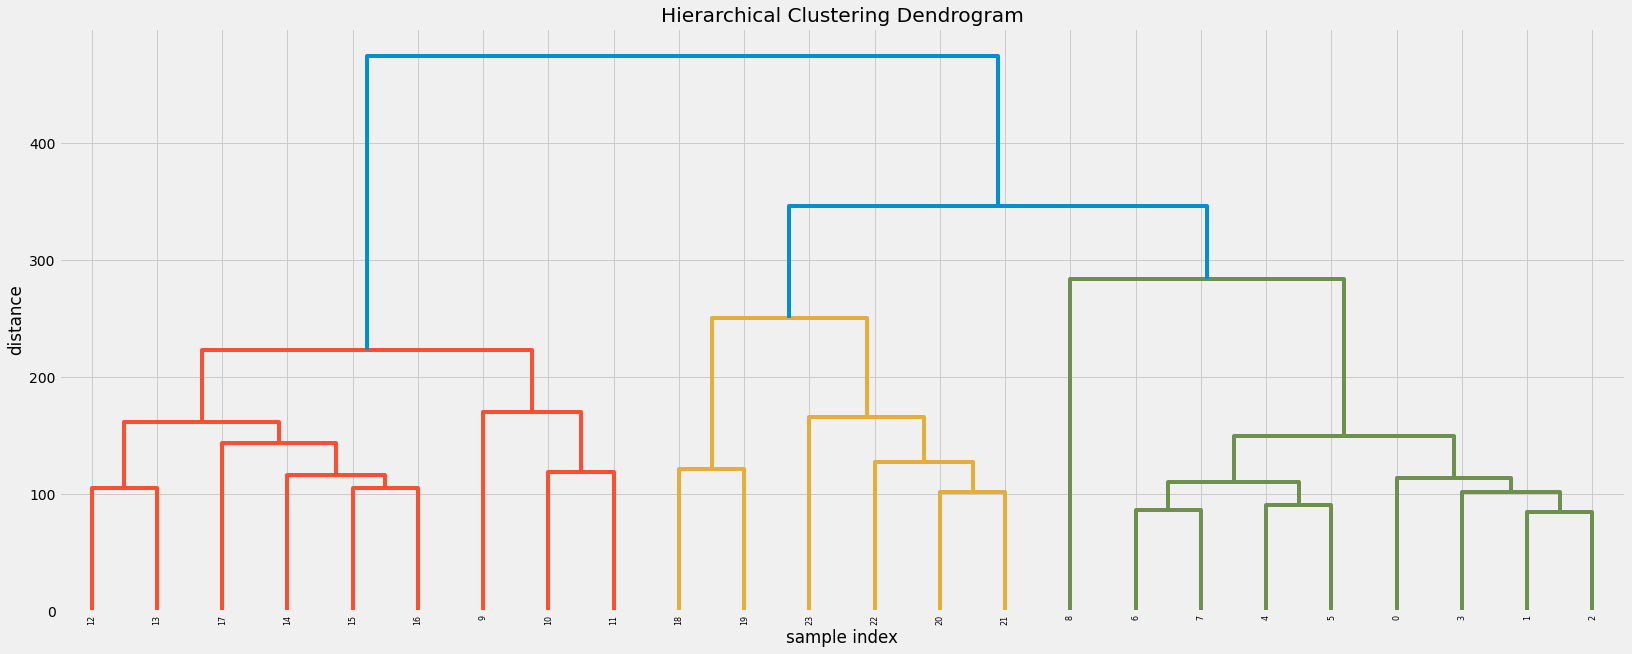

In [134]:
# Do the clustering
Z = hac.linkage(mySeries, method='average', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [135]:
print_clusters(mySeries, Z, 3, plot=False)

Cluster 3 number of entries 9
Cluster 1 number of entries 9
Cluster 2 number of entries 6


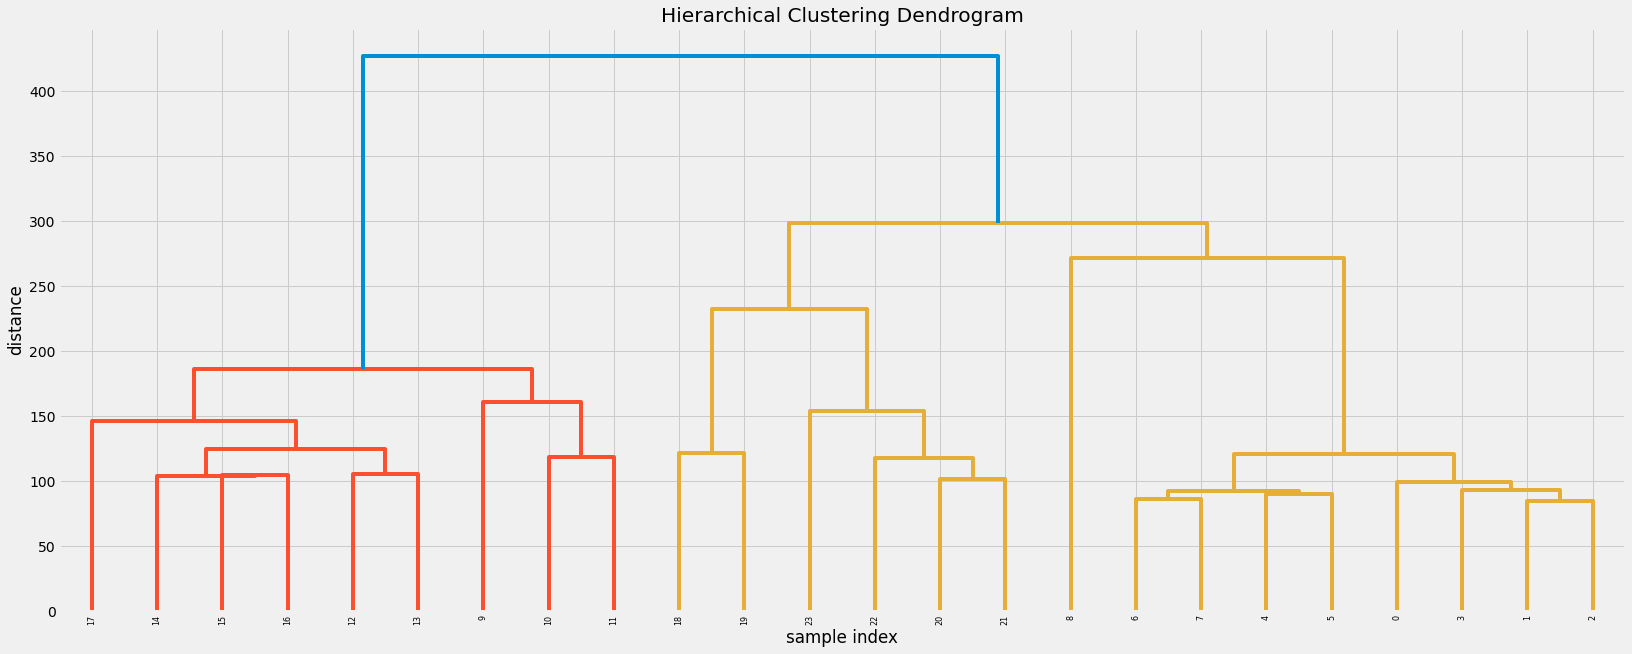

In [121]:
# Do the clustering
Z = hac.linkage(mySeries, method='centroid', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [123]:
print_clusters(mySeries, Z, 3, plot=False)

Cluster 3 number of entries 9
Cluster 1 number of entries 9
Cluster 2 number of entries 6


In [138]:
u1_pod[''].shape

(26304, 17)

## SOM

In [180]:
#mySeries

hulk = mySeries[0]

hulk1 = pd.DataFrame(hulk)

for i in range(24):
    hulk1[i] = mySeries[i].values

hulk1.drop(columns=['CONSUMO_ATTIVA_PRELEVATA'], inplace=True)
hulk1.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,64.50,64.35,64.05,63.60,64.20,67.05,63.90,63.45,63.15,63.90,...,65.10,65.25,64.20,64.05,64.35,64.20,64.35,64.50,64.95,64.50
2018-01-02,63.90,65.10,64.20,64.35,64.05,64.80,64.95,64.05,64.65,69.00,...,74.10,71.85,73.65,72.60,70.95,71.10,72.00,82.05,78.75,79.80
2018-01-03,79.05,79.05,80.10,79.35,78.75,78.00,78.60,81.15,78.60,80.40,...,71.70,71.70,70.80,72.00,70.35,67.95,66.15,66.60,76.65,75.30
2018-01-04,75.00,74.85,75.00,76.20,73.95,75.30,74.55,75.30,77.85,75.30,...,70.95,74.85,73.05,72.60,72.90,70.80,71.10,71.70,80.10,81.00
2018-01-05,78.75,80.10,78.60,79.80,79.95,76.20,75.60,75.00,75.90,79.35,...,72.15,72.75,70.95,72.30,71.55,71.85,71.25,71.70,81.30,76.35


In [188]:
hulk2 = hulk1.values
hulk3 = np.transpose(hulk2)
hulk3.shape

(24, 1096)

In [194]:
#hulk3

In [196]:
hulk2.shape

(1096, 24)

In [212]:
hulk3.shape

(24, 1096)

In [219]:
print(len(mySeries))
print(len(mySeries[0]))

24
1096


In [220]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

len_df = len(mySeries[0])

som = MiniSom(som_x, som_y, input_len=len_df, sigma=0.3, learning_rate = 0.1)

som.random_weights_init(hulk3)
som.train(hulk3, 50000)


In [221]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="blue")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

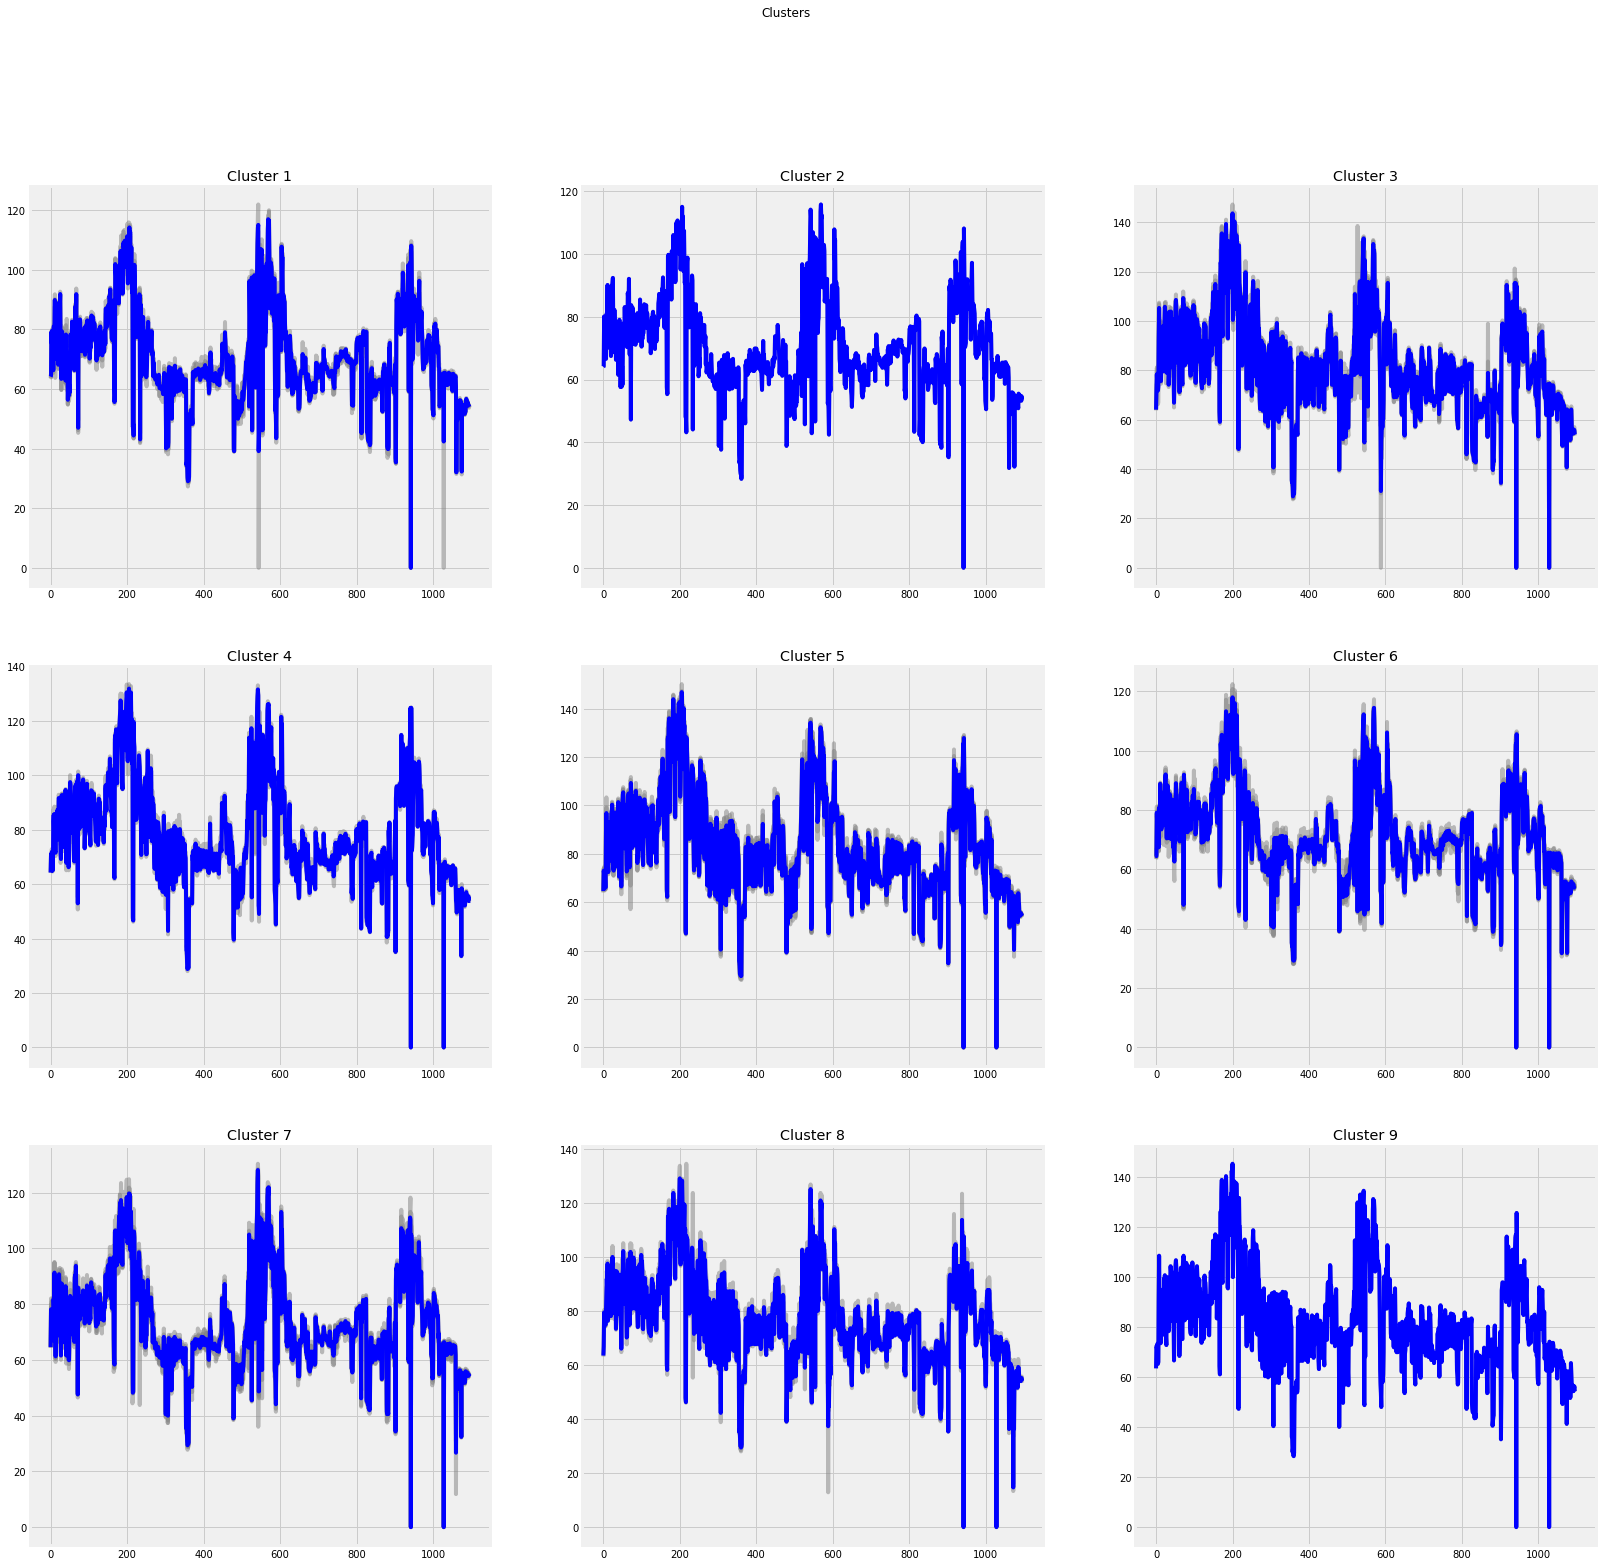

In [222]:
win_map = som.win_map(hulk3)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

In [223]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

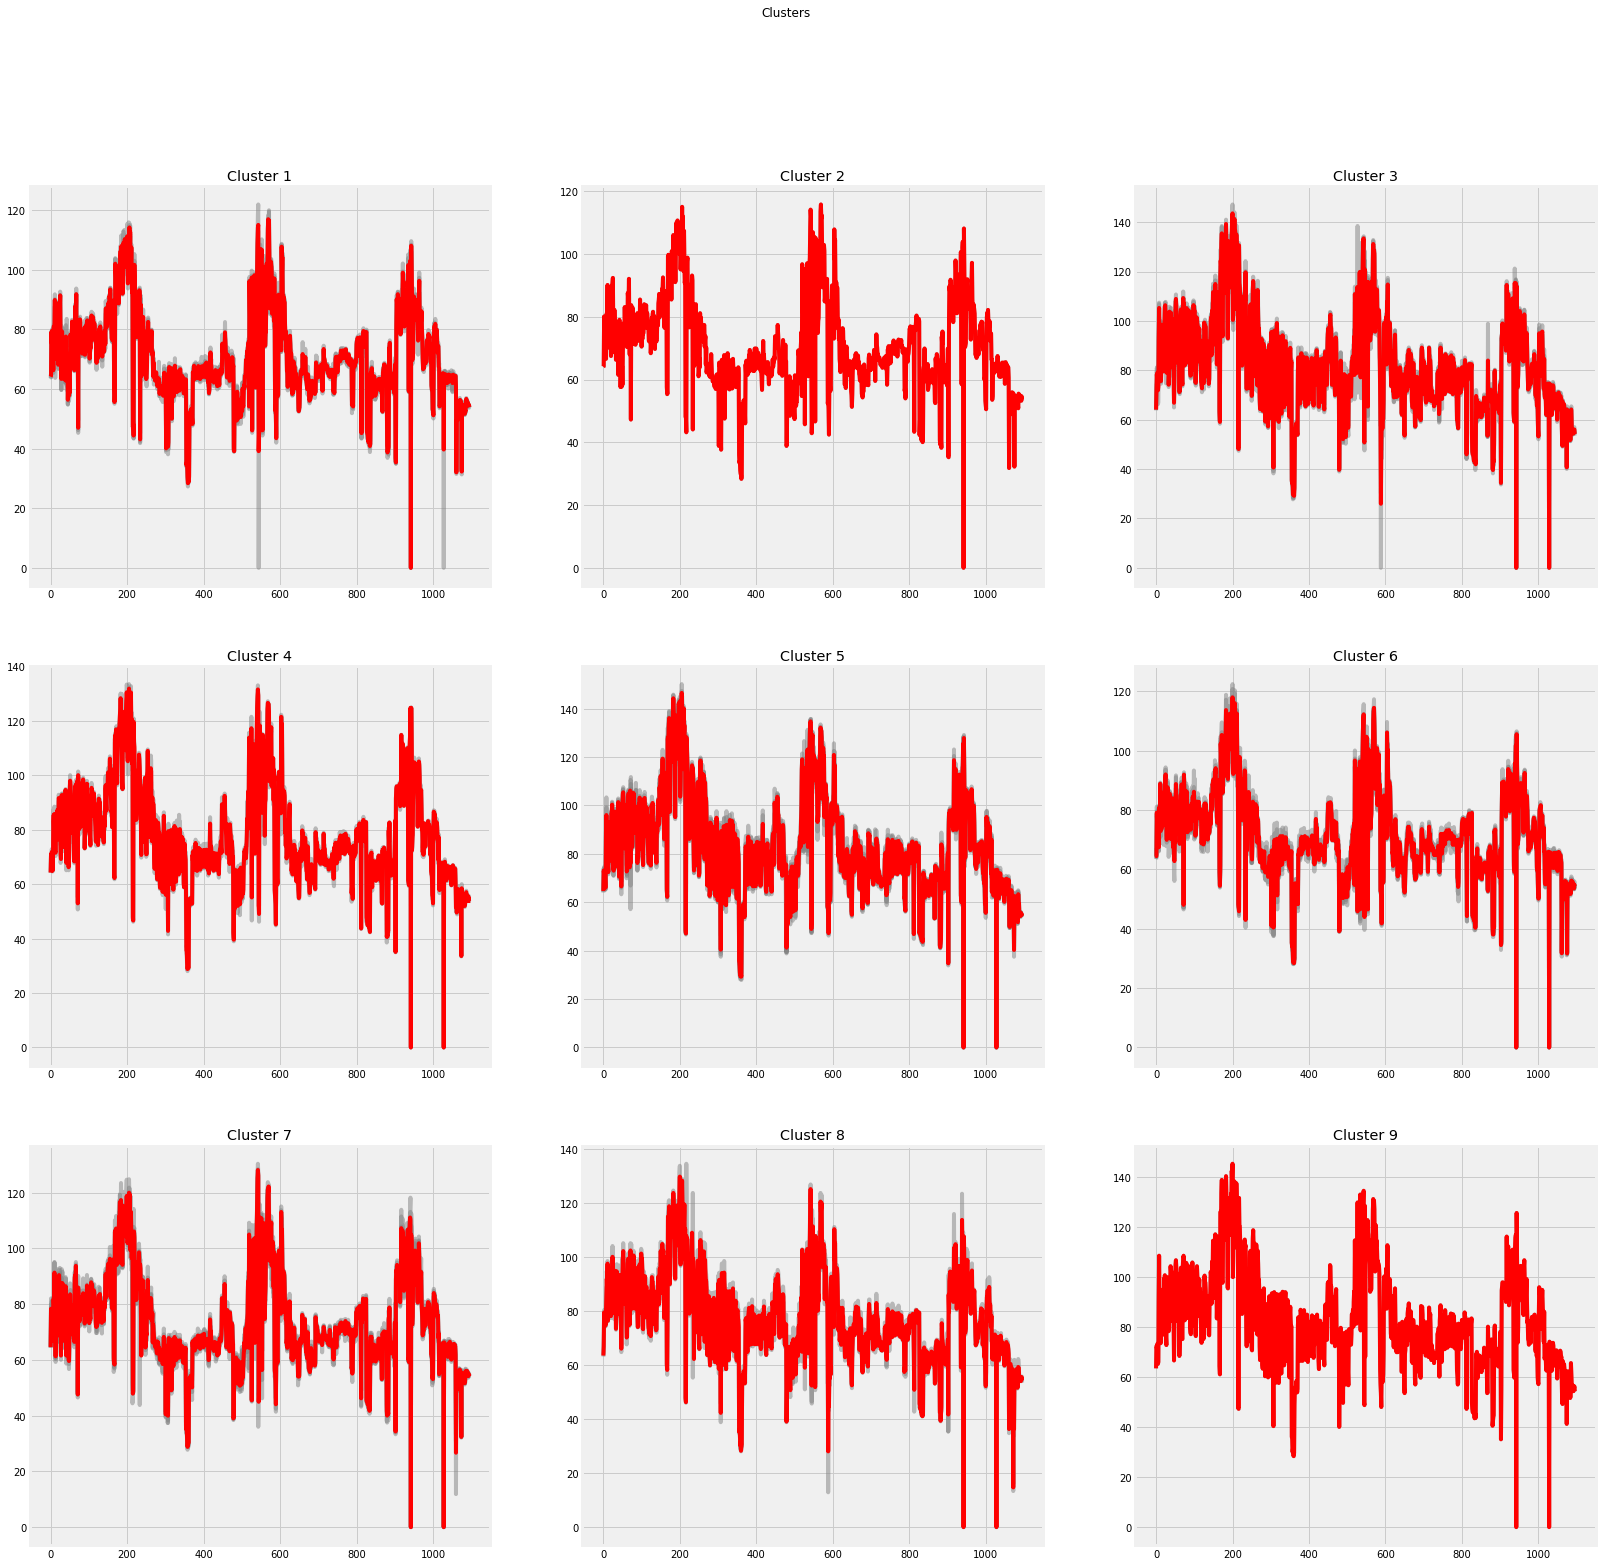

In [226]:
win_map = som.win_map(hulk3)

plot_som_series_dba_center(som_x, som_y, win_map)

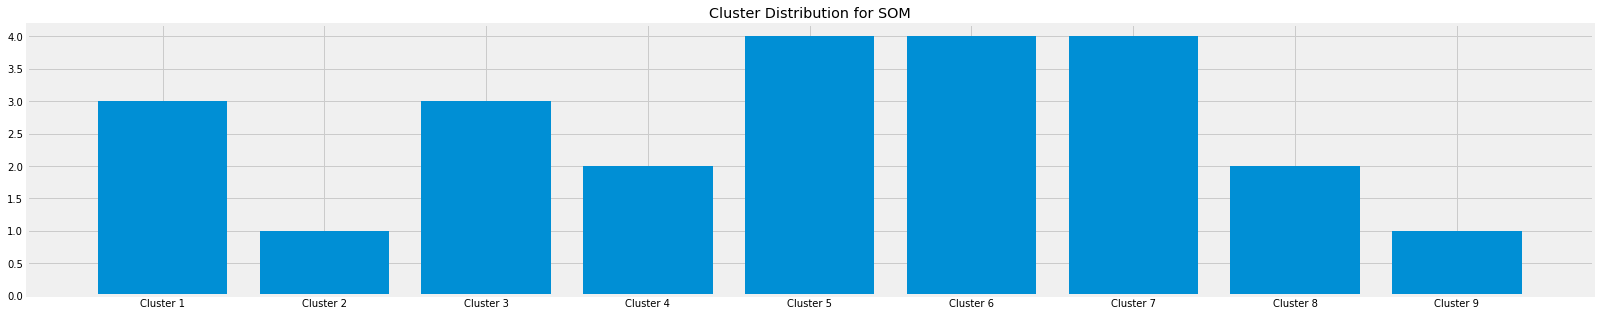

In [227]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

# SOM - Version #2

In [210]:
som = MiniSom(som_x, som_y, hulk2.shape[1], sigma=2., learning_rate=0.5, 
              neighborhood_function='gaussian', random_seed=10)
som.pca_weights_init(hulk2)
print("Training...")
som.train_batch(hulk2, 50000, verbose=True)  # random training
print("\n...ready!")

Training...
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 30.87170492271901

...ready!


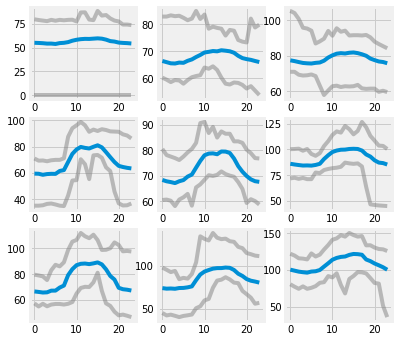

In [211]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

win_map = som.win_map(hulk2)

plt.figure(figsize=(16, 16))
the_grid = GridSpec(8, 8)
for position in win_map.keys():
    plt.subplot(the_grid[6-position[1], position[0]])
    plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
    plt.plot(np.mean(win_map[position], axis=0))
    plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)
#plt.savefig('resulting_images/time_series.png')
plt.show()

# K-Means Clustering

In [94]:
cluster_count = 3
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

In [95]:
cluster_hour = zip(list(range(24)), list(labels))
cluster_hour = list(cluster_hour)
cluster_hour

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 2),
 (9, 2),
 (10, 2),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 2),
 (19, 2),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1)]

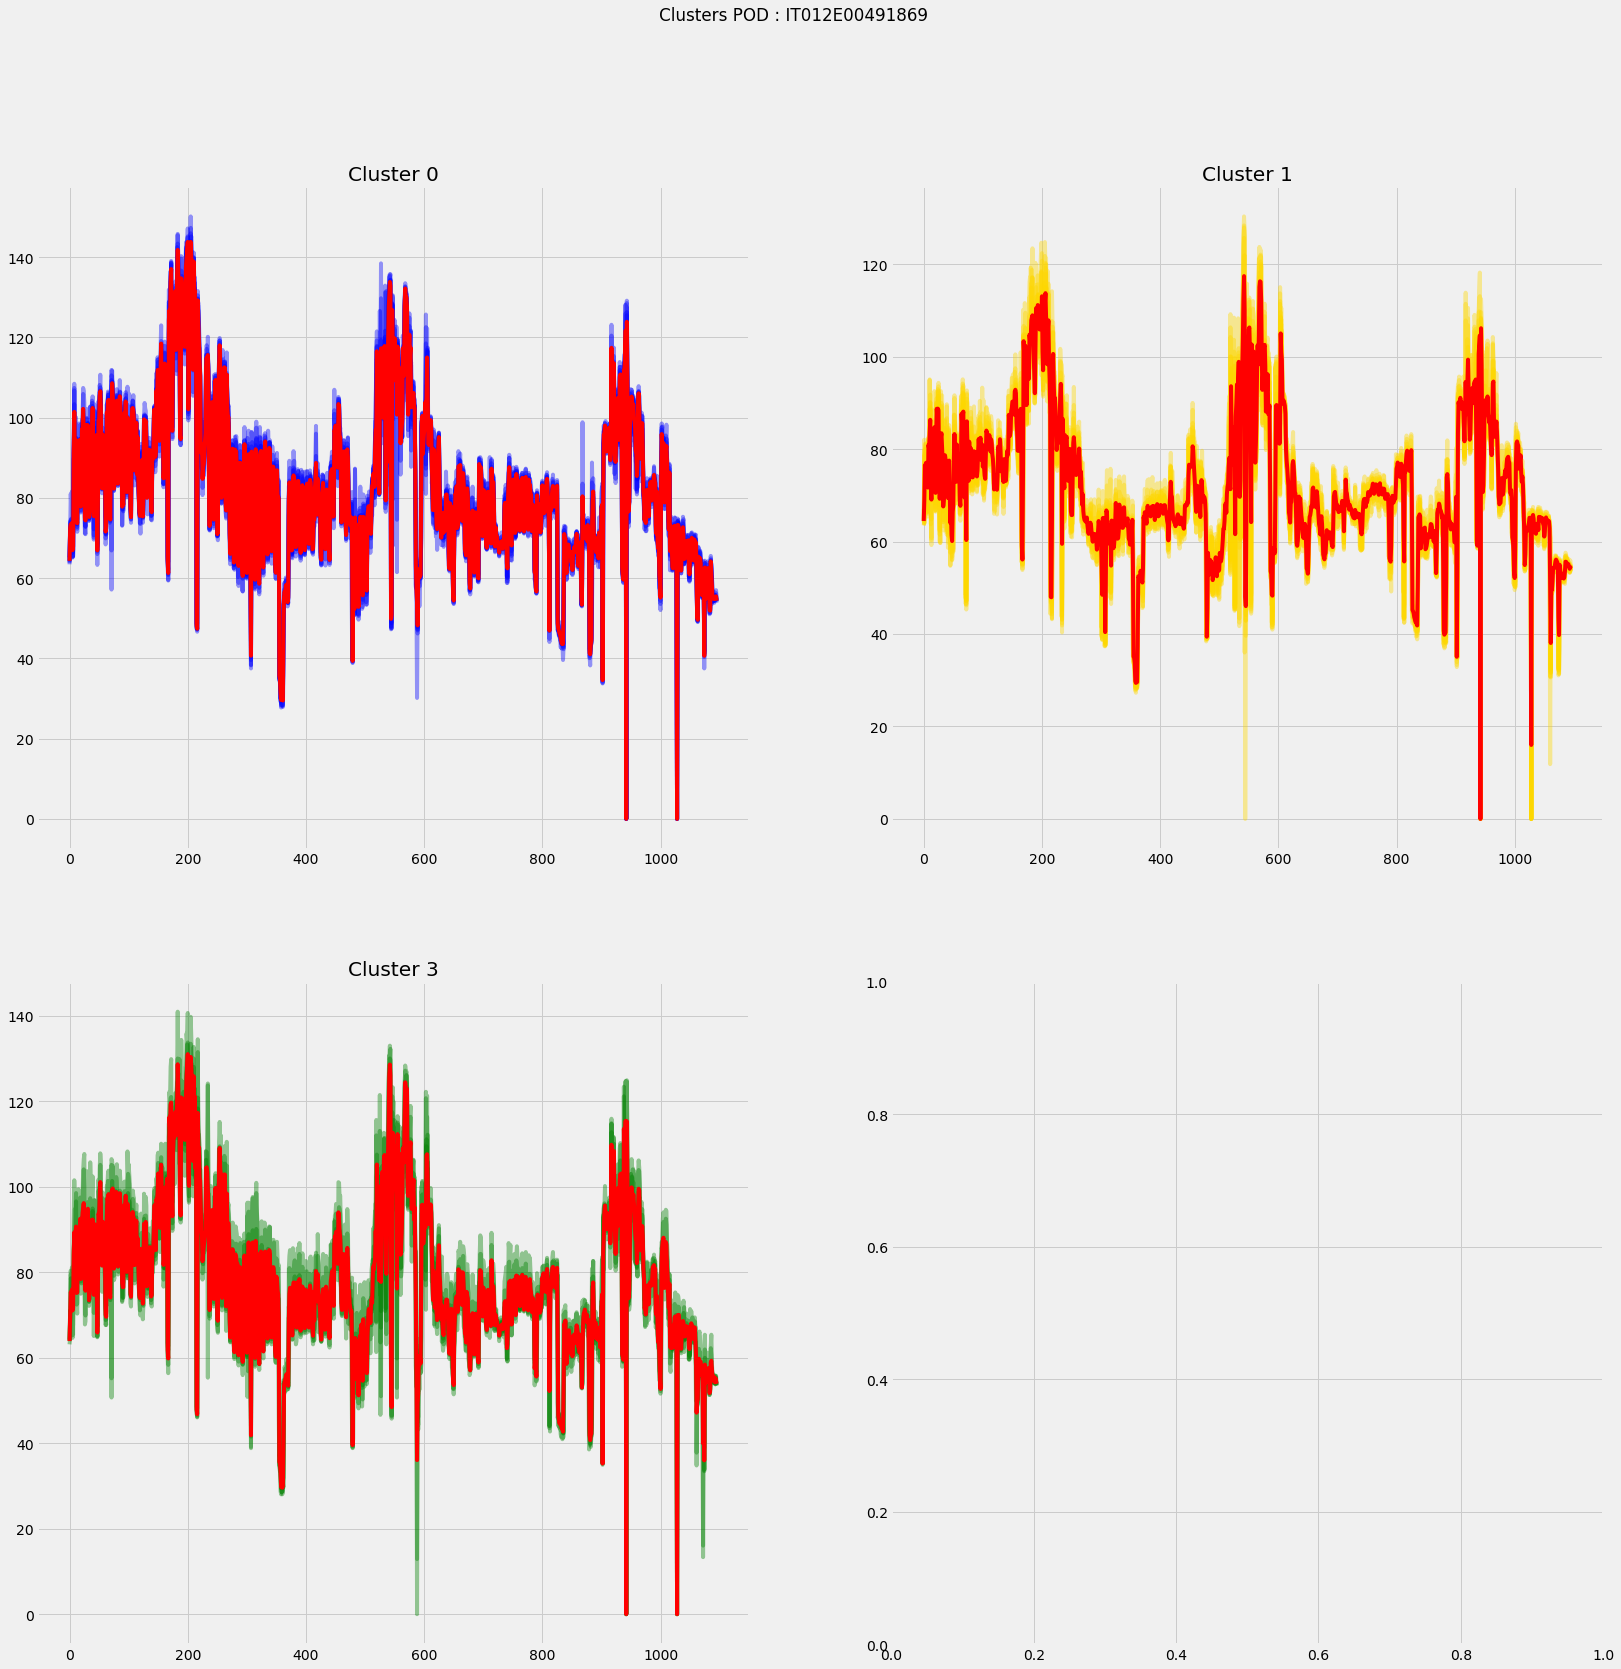

In [96]:
plot_count = math.ceil(math.sqrt(cluster_count))
cluster =[]
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25,25))
fig.suptitle(f'Clusters POD : {pod_list[1]}')
row_i=0
column_j=0
colors = ['blue', 'gold', 'green']
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i].values, c=colors[labels[i]], alpha=0.4)
                cluster.append(mySeries[i])
                axs[row_i, column_j].set_title("Cluster "+str(labels[i]))
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()